In [86]:
from hmmlearn import hmm
from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.preprocessing import MinMaxScaler
from matplotlib import cm, pyplot as plt
import pickle
import warnings
from math import sqrt
import numpy
import pyedflib
import numpy as np
import time
start_time = time.time()
np.random.seed(111)


In [87]:
def load_data(filename):
    g = pyedflib.EdfReader(filename)
    n = g.signals_in_file
    signal_labels = g.getSignalLabels()
    sig = np.zeros((n, g.getNSamples()[0]))
    for i in np.arange(n):
        len_sig = len(g.readSignal(i))
        sig[i, :len_sig] = g.readSignal(i)
    return sig

# create a differenced series
def difference(dataset, interval=1):
    diff = np.zeros((dataset.shape[0],dataset.shape[1]))
    for k in range(dataset.shape[0]):
        for i in range(interval, dataset.shape[1]):
            diff[k,i] = dataset[k,i] - dataset[k,i - interval]
            
    return diff

# scale train and test data to [-1, 1]
def scale_t(data):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    data = data.reshape(-1, 1)
    #scaler = StandardScaler()
    scaler = scaler.fit(data)
    # transform data
    print(data.shape[0])
    
    data_scaled = scaler.transform(data)
    
    return scaler, data_scaled

def make_data(sig, normalise_window):
    data = sig[:2,:10000]
    data_scale = np.zeros(data.shape)
    for i in range(data.shape[0]):
        scaler, data_s = scale_t(data[i])
        data_scale[i] = data_s[:,0]
    if not normalise_window:
        data_diff = difference(data_scale,1)
    
    row = round(0.9 * data_diff.shape[1])
    data_diff = data_diff.T
    train = data_diff[:int(row), :]
    test = data_diff[int(row):, :]
    
    
    #print(train_scaled.shape,test_scaled.shape)  
    #print(train_scaled[0],test_scaled[0])
    #np.random.shuffle(train)
    return [scalers, train, test]

In [88]:
print('> Loading data... ')
sig = load_data('LSTM/sample-data/SC4001E0-PSG.edf')
print("--- %s seconds ---" % (time.time() - start_time))

> Loading data... 
--- 3.09392595291 seconds ---


In [89]:
scalers, train, test = make_data(sig, False)
print(train.shape, test.shape)

10000
10000
((9000, 2), (1000, 2))


In [90]:
model_3 = hmm.GaussianHMM(n_components=4, covariance_type="diag", n_iter = 500, verbose=True).fit(train)
print(model_3.means_)
print(model_3.covars_)
print(model_3.startprob_)
print(model_3.transmat_)
z = model_3.predict(train)
print z.shape

         1       11592.3908             +nan
         2       17377.7393       +5785.3485
         3       18155.0858        +777.3465
         4       18476.7988        +321.7130
         5       18630.5003        +153.7015
         6       18713.7800         +83.2797
         7       18761.6129         +47.8328
         8       18790.8075         +29.1946
         9       18810.8545         +20.0470
        10       18827.1149         +16.2604
        11       18842.0154         +14.9005
        12       18856.3307         +14.3153
        13       18870.1324         +13.8017
        14       18883.2257         +13.0933
        15       18895.3590         +12.1333
        16       18906.3412         +10.9822
        17       18916.1755          +9.8343
        18       18925.1172          +8.9417
        19       18933.5178          +8.4005
        20       18941.7106          +8.1929
        21       18949.9988          +8.2882
        22       18958.6652          +8.6663
        23

[[-1.80437411e-03  1.14186106e-04]
 [ 1.27802123e-03 -1.70122776e-04]
 [-7.35048200e-03  1.59933229e-03]
 [ 1.75922869e-03  9.66417723e-05]]
[[[0.01057109 0.        ]
  [0.         0.01276391]]

 [[0.00148868 0.        ]
  [0.         0.00515905]]

 [[0.06619017 0.        ]
  [0.         0.11022173]]

 [[0.00478277 0.        ]
  [0.         0.08226158]]]
[1.43154688e-051 1.00000000e+000 4.76893854e-203 3.98303312e-188]
[[8.89284330e-01 1.07898866e-01 1.45235425e-03 1.36444884e-03]
 [6.78561499e-02 9.32142916e-01 5.28779936e-17 9.33670686e-07]
 [1.50378780e-02 6.40899250e-19 8.80885463e-01 1.04076659e-01]
 [4.87902143e-03 2.28959441e-03 4.06695867e-02 9.52161797e-01]]
(9000,)


        76       19660.1517          +0.0088


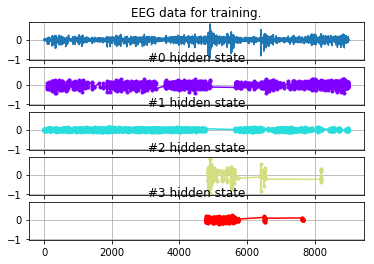

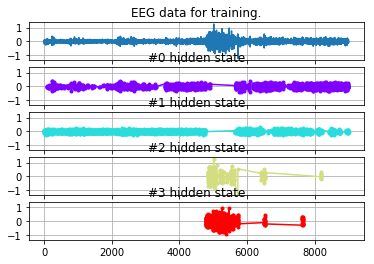

In [91]:
for k in range(train.shape[1]):
    fig, axs = plt.subplots(model_3.n_components+1, sharex=True, sharey=True)
    colours = cm.rainbow(np.linspace(0, 1, model_3.n_components))
    time = np.arange(len(train))
    axs[0].plot(time, train[:,k])
    axs[0].set_title("EEG data for training.")
    axs[0].grid(True)
    train_k = train[:,k]
    
    for i  in range(1,model_3.n_components+1):
        mask = z == i-1
        #print(time[mask])
        axs[i].plot(time[mask], train_k[mask], ".-", c=colours[i-1])
        axs[i].set_title("#{0} hidden state".format(i-1))

        axs[i].grid(True)
    

    plt.show()

In [92]:
from sklearn.utils import check_random_state

L=len(test) # We would like to predict the following 15 days' trend
Niter = 10 # A hyper parameter of generating samples

warnings.filterwarnings('ignore')
eeg0 = train
eeg2 = np.copy(train)

startprob_cdf = np.cumsum(model_3.startprob_)
transmat_cdf = np.cumsum(model_3.transmat_, axis=1)
random_state = model_3.random_state

rs = check_random_state(None)

for l in range(L):
    eeg2 = np.append(eeg2,[[0,0]],axis=0) # Add a pair of empty (d,v)
    true_eeg = np.copy(eeg0[:len(train)+l])
    #print(true_eeg.shape)
    state_seq = model_3.predict(true_eeg)
    previous_state = state_seq[-1]

    maxLL = -1e10
    for n in range(Niter):
        currstate = (transmat_cdf[previous_state]> rs.rand() ).argmax() # Go through transmat to get a new state

        new_sample = model_3._generate_sample_from_state(currstate) # generate from the new state
        tmp_eeg = np.copy(true_eeg)
        tmp_eeg = np.append(tmp_eeg,[new_sample],axis=0) # Append the new_sample for score
        tmp_maxLL = model_3.score(tmp_eeg) # 
        if tmp_maxLL > maxLL :

                maxLL = tmp_maxLL
                eeg2[-1] = new_sample[0]


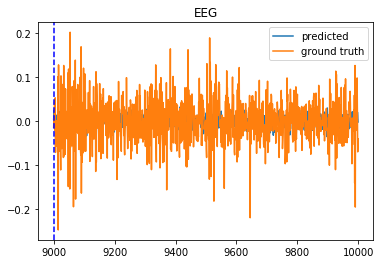

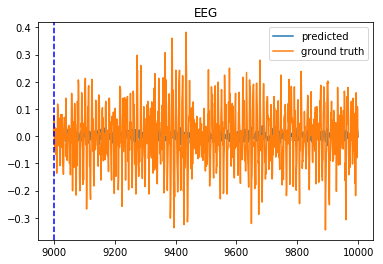

In [94]:
# The curve after day 100 is the predicted trend.

time2 = time = np.arange(len(eeg2))
#print (len(time2))
plt.figure()
#print(eeg2)

for k in range(train.shape[1]):
    plt.plot(time2[(train.shape[0]):], eeg2[(train.shape[0]):,k])
    #print( np.concatenate([train[x=train.shape[0] + 1,k],test[x=train.shape[0] + 1,k]]).shape)
    plt.plot(time2[(train.shape[0]):], test[:,k])#[100:100+25])
    plt.legend(('predicted', 'ground truth'))
    plt.axvline(x=train.shape[0] + 1, linestyle='--', color = 'b', label = 'future predicted points')
    plt.title("EEG")
    plt.show()